# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with interactions and polynomial features 
- Use AIC and BIC to select the best value for the regularization parameter 


## Let's get started!

Import all the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

Load the data.

In [2]:
df = pd.read_csv("ames.csv")

In [3]:
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

In [4]:
df.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,SalePrice
0,8450,7,5,856,856,854,1710,8,548,0,208500
1,9600,6,8,1262,1262,0,1262,6,460,1,181500
2,11250,7,5,920,920,866,1786,6,608,1,223500
3,9550,7,5,756,961,756,1717,7,642,1,140000
4,14260,8,5,1145,1145,1053,2198,9,836,1,250000


## Look at a baseline housing data model

Above, we imported the Ames housing data and grabbed a subset of the data to use in this analysis.

Next steps:

- Split the data into target (`y`) and predictors (`X`) -- ensure these both are DataFrames 
- Scale all the predictors using `scale`. Convert these scaled features into a DataFrame 
- Build at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation (set `random_state` to 1) and use the $R^2$ score to evaluate the model 

In [5]:
# Your code here
y = df.SalePrice
X = df.drop('SalePrice', axis=1)

In [6]:
# scale predictors using scale
X_scaled = pd.DataFrame(scale(X), columns=X.columns)

In [7]:
kf = KFold(n_splits=5, random_state=1)

train_r2 = []
val_r2 = []

for train_idx, val_idx in kf.split(X_scaled, y):
    X_train_fold, y_train_fold = X_scaled.iloc[train_idx], y.iloc[train_idx]
    X_val_fold, y_val_fold = X_scaled.iloc[val_idx], y.iloc[val_idx]
    
    # fit the model
    lr = LinearRegression()
    lr.fit(X_train_fold, y_train_fold)
    
    # append R2 scores to lists
    train_r2.append(lr.score(X_train_fold, y_train_fold))
    val_r2.append(lr.score(X_val_fold, y_val_fold))

In [8]:
# Mean Train R2
np.mean(train_r2)

0.7691524993051603

In [9]:
# Mean Validation R2
np.mean(val_r2)

0.7569110039304656

In [10]:
# OR, we can also do it like this using cross_val_score
# which will return an array of validation R2
baseline = LinearRegression()
baseline.fit(X_scaled, y)

print(cross_val_score(baseline, X_scaled, y, cv=5))

[0.81590682 0.78658346 0.77744573 0.77448228 0.63013673]


In [11]:
baseline_score = np.mean(cross_val_score(baseline, X_scaled, y, cv=5))

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold cross-validation and store the $R^2$ to compare it with the baseline model.

Print the 7 most important interactions.

In [12]:
from itertools import combinations

pairs = list(combinations(X.columns, 2))

val_r2_dict = {}
X_interact = X_scaled.copy()

for f1, f2 in pairs:
    X_interact['interaction'] = X_scaled[f1] * X_scaled[f2]
    
    lr = LinearRegression()
    lr.fit(X_interact, y)
    
    score = np.mean(cross_val_score(lr, X_interact, y, cv=5))
    # Only append scores that are higher than baseline_score to dictionary
    if score > baseline_score:
        val_r2_dict[f'{f1}-{f2}'] = score

In [13]:
# Sort val_r2_dict by values
sorted_val_r2 = sorted(val_r2_dict.items(), key=lambda i: i[1], reverse=True)
top_7_interactions = sorted_val_r2[:7]
print('Interaction\t\t\tScore')
print()
for pair, score in top_7_interactions:
    print(f'{pair:25}\t{score}')

Interaction			Score

OverallQual-TotRmsAbvGrd 	0.775191378432255
OverallQual-GarageArea   	0.7726987805453559
LotArea-1stFlrSF         	0.7666267582484567
LotArea-TotalBsmtSF      	0.76619804450317
OverallQual-Fireplaces   	0.7643358376077852
OverallQual-2ndFlrSF     	0.762195326826904
2ndFlrSF-GarageArea      	0.7599674685318546


Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2", where var1 and var2 are the two variables in the interaction.

In [14]:
X_inter = X_scaled.copy()

for pair, _ in top_7_interactions:
    f1, f2 = pair.split('-')
    X_inter[pair] = X_scaled[f1] * X_scaled[f2]
     
X_inter.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,OverallQual-TotRmsAbvGrd,OverallQual-GarageArea,LotArea-1stFlrSF,LotArea-TotalBsmtSF,OverallQual-Fireplaces,OverallQual-2ndFlrSF,2ndFlrSF-GarageArea
0,-0.207142,0.651479,-0.517200,-0.459303,-0.793434,1.161852,0.370333,0.912210,0.351000,-0.951226,0.594286,0.228669,0.164353,0.095141,-0.619704,0.756922,0.407810
1,-0.091886,-0.071836,2.179628,0.466465,0.257140,-0.795163,-0.482512,-0.318683,-0.060731,0.600495,0.022893,0.004363,-0.023628,-0.042862,-0.043137,0.057121,0.048291
2,0.073480,0.651479,-0.517200,-0.313369,-0.627826,1.189351,0.515013,-0.318683,0.631726,0.600495,-0.207616,0.411557,-0.046133,-0.023026,0.391210,0.774837,0.751344
3,-0.096897,0.651479,-0.517200,-0.687324,-0.521734,0.937276,0.383659,0.296763,0.790804,0.600495,0.193335,0.515193,0.050555,0.066600,0.391210,0.610616,0.741202
4,0.375148,1.374795,-0.517200,0.199680,-0.045611,1.617877,1.299326,1.527656,1.698485,0.600495,2.100214,2.335068,-0.017111,0.074910,0.825557,2.224249,2.747940


## Include polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('OverallQual', 2, 0.781)` 

In [15]:
# Your code here
degrees = [2, 3, 4]

poly_list = []

for feature in X.columns:
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        feature_poly = pd.DataFrame(poly.fit_transform(X_scaled[[feature]]), 
                                    columns=[feature + str(d) for d in range(degree)])
        X_all = pd.concat([X_inter.drop(feature, axis=1), feature_poly], axis=1)
        
        lr = LinearRegression()
        lr.fit(X_interact, y)
        
        score = np.mean(cross_val_score(lr, X_all, y, cv=5))
        
        # Only append scores that are higher than baseline_score to dictionary
        if score > baseline_score:
            poly_list.append((feature, degree, score))

For each variable, print out the maximum $R^2$ possible when including Polynomials.

In [16]:
poly_df = pd.DataFrame(poly_list, columns=['Feature', 'Degree', 'R2'])
sorted_poly = poly_df.groupby('Feature').max('R2')
sorted_poly

,Degree,R2
Feature,,
1stFlrSF,3,0.836375
2ndFlrSF,4,0.807223
Fireplaces,4,0.795625
GarageArea,4,0.804552
GrLivArea,4,0.803509
LotArea,4,0.799422
OverallCond,4,0.795588
OverallQual,4,0.796538
TotRmsAbvGrd,4,0.793491


Which two variables seem to benefit most from adding polynomial terms?

The two variables that seem to benefit the most from adding polynomial terms are `1stFlrSF` and `2ndFlrSF`.

In [17]:
top_2_poly = sorted_poly[:2]

Add Polynomials for the two features that seem to benefit the most, as in have the best $R^2$ compared to the baseline model. For each of the two features, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [18]:
# Your code here
for f in top_2_poly.index:
    degree = int(top_2_poly.loc[f].Degree)
    X_inter[f'{f}_{str(degree)}'] = (X_inter[f])**degree

Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [19]:
# Your code here
X_inter.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,OverallQual-TotRmsAbvGrd,OverallQual-GarageArea,LotArea-1stFlrSF,LotArea-TotalBsmtSF,OverallQual-Fireplaces,OverallQual-2ndFlrSF,2ndFlrSF-GarageArea,1stFlrSF_3,2ndFlrSF_4
0,-0.207142,0.651479,-0.517200,-0.459303,-0.793434,1.161852,0.370333,0.912210,0.351000,-0.951226,0.594286,0.228669,0.164353,0.095141,-0.619704,0.756922,0.407810,-0.499496,1.822228
1,-0.091886,-0.071836,2.179628,0.466465,0.257140,-0.795163,-0.482512,-0.318683,-0.060731,0.600495,0.022893,0.004363,-0.023628,-0.042862,-0.043137,0.057121,0.048291,0.017002,0.399784
2,0.073480,0.651479,-0.517200,-0.313369,-0.627826,1.189351,0.515013,-0.318683,0.631726,0.600495,-0.207616,0.411557,-0.046133,-0.023026,0.391210,0.774837,0.751344,-0.247467,2.000966
3,-0.096897,0.651479,-0.517200,-0.687324,-0.521734,0.937276,0.383659,0.296763,0.790804,0.600495,0.193335,0.515193,0.050555,0.066600,0.391210,0.610616,0.741202,-0.142019,0.771739
4,0.375148,1.374795,-0.517200,0.199680,-0.045611,1.617877,1.299326,1.527656,1.698485,0.600495,2.100214,2.335068,-0.017111,0.074910,0.825557,2.224249,2.747940,-0.000095,6.851447


## Full model R-squared

Check out the $R^2$ of the full model.

In [20]:
# Your code here
linreg_full = LinearRegression()
linreg_full.fit(X_inter, y)
np.mean(cross_val_score(linreg_full, X_inter, y, cv=5))

0.8454533804442109

## Find the best Lasso regularization parameter

You learned that when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter $alpha$ of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [21]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC

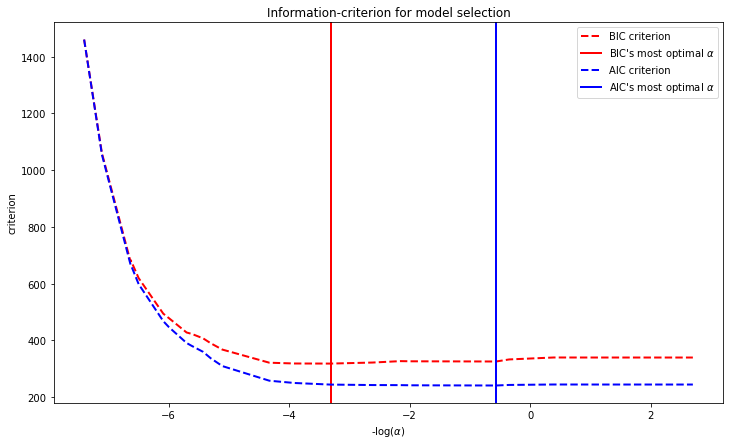

In [29]:
# Your code here 
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_inter, y)
alpha_bic = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_inter, y)
alpha_aic = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.plot(-np.log(model.alphas_), criterion_, color=color, linestyle='--',
             linewidth=2, label=f'{name} criterion')
    plt.axvline(-np.log(model.alpha_), color=color, linewidth=2,
                label=fr"{name}'s most optimal $\alpha$")
    plt.xlabel(r'-log($\alpha$)')
    plt.ylabel('criterion')
    
plt.figure(figsize=(12,7))
plot_ic_criterion(model_bic, 'BIC', 'red')
plot_ic_criterion(model_aic, 'AIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection');

## Analyze the final result

Finally, use the best value for the regularization parameter according to AIC and BIC, and compare $R^2$ and RMSE using train-test split. Compare with the baseline model.

Remember, you can find the Root Mean Squared Error (RMSE) by setting `squared=False` inside the function (see [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)), and the RMSE returns values that are in the same units as our target - so we can see how far off our predicted sale prices are in dollars.

In [23]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

In [30]:
# Split X_scaled and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_inter, y)

# Code for baseline model
linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)

# Generate predictions
y_pred_train = linreg_all.predict(X_train)
y_pred_test = linreg_all.predict(X_test)

# Print R-Squared and RMSE
print("-------------------------Baseline-------------------------")
print()
print("\t\tR-Squared\t\tRMSE")
print(f"Training\t{linreg_all.score(X_train, y_train)}\t{mean_squared_error(y_train, y_pred_train, squared=False)}")
print(f"Testing\t\t{linreg_all.score(X_test, y_test)}\t{mean_squared_error(y_test, y_pred_test, squared=False)}")

-------------------------Baseline-------------------------

		R-Squared		RMSE
Training	0.8577413981504157	30195.827524205863
Testing		0.848090398008886	30185.909700126842


In [25]:
# Split df_inter and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_inter, y, random_state=1)

In [31]:
# Code for lasso with alpha from AIC
lasso = Lasso(alpha=alpha_aic)
lasso.fit(X_train, y_train)

# Generate predictions
y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

# Print R-Squared and RMSE
# Print R-Squared and RMSE
print("-------------------------Lasso BIC-------------------------")
print()
print("\t\tR-Squared\t\tRMSE")
print(f"Training\t{lasso.score(X_train, y_train)}\t{mean_squared_error(y_train, y_pred_train_lasso, squared=False)}")
print(f"Testing\t\t{lasso.score(X_test, y_test)}\t{mean_squared_error(y_test, y_pred_test_lasso, squared=False)}")

-------------------------Lasso BIC-------------------------

		R-Squared		RMSE
Training	0.8577410004158728	30195.869735766748
Testing		0.8480577585882975	30189.152410503222


In [32]:
# Code for lasso with alpha from BIC
lasso = Lasso(alpha=alpha_bic)
lasso.fit(X_train, y_train)

# Generate predictions
y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

# Print R-Squared and RMSE
# Print R-Squared and RMSE
print("-------------------------Lasso BIC-------------------------")
print()
print("\t\tR-Squared\t\tRMSE")
print(f"Training\t{lasso.score(X_train, y_train)}\t{mean_squared_error(y_train, y_pred_train_lasso, squared=False)}")
print(f"Testing\t\t{lasso.score(X_test, y_test)}\t{mean_squared_error(y_test, y_pred_test_lasso, squared=False)}")

-------------------------Lasso BIC-------------------------

		R-Squared		RMSE
Training	0.85764531618213	30206.022987915585
Testing		0.8475006386515174	30244.44838802167


## Level up (Optional)

### Create a Lasso path

From this section, you know that when using Lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Ames housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 